# Clasificación basado en Descriptores de Textura LBP

## Resumen Ejecutivo
Este documento presenta la implementación y evaluación de un sistema de clasificación automatizada para personajes de Los Simpsons utilizando exclusivamente descriptores de textura Local Binary Patterns (LBP). El enfoque desarrollado se centra en la extracción y análisis de características microestructurales para la diferenciación entre Bart Simpson y Homer Simpson.

## 1. Configuración del Entorno Experimental

Esta sección establece los parámetros fundamentales del sistema experimental, incluyendo la configuración de algoritmos, rutas de datos y parámetros de procesamiento que garantizan la reproducibilidad y estandarización de los resultados obtenidos.

In [1]:
# ============================================================================
# CONSTANTES DEL PROYECTO
# ============================================================================

import os
from pathlib import Path

# Configuración de rutas usando os.path.join()
PROJECT_ROOT = "d:\\dom1nux\\Repos\\University\\si_proyecto_unidad_2_final" # Ruta raíz del proyecto
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "simpsons")
TRAINING_DIR = os.path.join(DATA_DIR, "training")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Configuración de clases
CLASSES = ("bart_simpson", "homer_simpson")
CLASS_NAMES = ["Bart Simpson", "Homer Simpson"]

# Configuración de imágenes
IMAGE_SIZE = (128, 128)
VALID_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")

# Configuración de LBP
LBP_RADIUS = 1
LBP_N_POINTS = 8
LBP_METHOD = 'uniform'

# Configuración de modelos
RANDOM_STATE = 42
TEST_SIZE = 0.3
CV_FOLDS = 5

# Configuración de visualizaciones
FIGURE_SIZE_SINGLE = (8, 6)
FIGURE_SIZE_MULTIPLE = (16, 12)
COLORMAP = 'Blues'

# Parámetros para GridSearch
GRID_SEARCH_PARAMS = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

# Valores de K para KNN
K_VALUES = [1, 3, 5, 7, 9]
DEFAULT_K = 5

print("✅ Constantes del proyecto configuradas correctamente")
print(f"📁 Directorio del proyecto: {PROJECT_ROOT}")
print(f"📂 Directorio de datos: {DATA_DIR}")
print(f"🏷️  Clases: {CLASSES}")
print(f"📐 Tamaño de imagen: {IMAGE_SIZE}")
print(f"🔢 Semilla aleatoria: {RANDOM_STATE}")

✅ Constantes del proyecto configuradas correctamente
📁 Directorio del proyecto: d:\dom1nux\Repos\University\si_proyecto_unidad_2_final
📂 Directorio de datos: d:\dom1nux\Repos\University\si_proyecto_unidad_2_final\data\simpsons
🏷️  Clases: ('bart_simpson', 'homer_simpson')
📐 Tamaño de imagen: (128, 128)
🔢 Semilla aleatoria: 42


### 1.1 Arquitectura de Configuración Centralizada

La implementación utiliza un sistema de constantes centralizadas que proporciona las siguientes ventajas metodológicas:

**Mantenibilidad**: Modificaciones de configuración centralizadas en un único punto de control
**Consistencia**: Aplicación uniforme de parámetros en todo el pipeline experimental
**Reproducibilidad**: Control determinístico mediante semilla aleatoria fija
**Organización**: Estructura jerárquica clara de rutas y configuraciones
**Escalabilidad**: Facilita la modificación de parámetros de visualización y algoritmos

Esta arquitectura garantiza que todas las funciones y modelos implementados utilicen configuraciones consistentes de manera automática.

## 2. Metodología de Carga y Preprocesamiento de Datos

Esta fase comprende la implementación del sistema de carga de imágenes y la extracción de etiquetas correspondientes, estableciendo el fundamento del dataset experimental para el análisis posterior.

In [2]:
%conda install opencv-python
# %pip install scikit-image
# %pip install scikit-learn
%conda install matplotlib
# %pip install pandas
# %pip install numpy


Note: you may need to restart the kernel to use updated packages.



CondaToSNonInteractiveError: Terms of Service have not been accepted for the following channels. Please accept or remove them before proceeding:
    • https://repo.anaconda.com/pkgs/main
    • https://repo.anaconda.com/pkgs/r
    • https://repo.anaconda.com/pkgs/msys2

To accept a channel's Terms of Service, run the following and replace `CHANNEL` with the channel name/URL:
    ‣ conda tos accept --override-channels --channel CHANNEL

To remove channels with rejected Terms of Service, run the following and replace `CHANNEL` with the channel name/URL:
    ‣ conda config --remove channels CHANNEL




Note: you may need to restart the kernel to use updated packages.



CondaToSNonInteractiveError: Terms of Service have not been accepted for the following channels. Please accept or remove them before proceeding:
    • https://repo.anaconda.com/pkgs/main
    • https://repo.anaconda.com/pkgs/r
    • https://repo.anaconda.com/pkgs/msys2

To accept a channel's Terms of Service, run the following and replace `CHANNEL` with the channel name/URL:
    ‣ conda tos accept --override-channels --channel CHANNEL

To remove channels with rejected Terms of Service, run the following and replace `CHANNEL` with the channel name/URL:
    ‣ conda config --remove channels CHANNEL



In [3]:
import cv2
import numpy as np
from collections import Counter

def cargar_dataset(ruta_base=None, clases=CLASSES, size=IMAGE_SIZE, verbose=True):
    """
    Carga el dataset de imágenes usando las constantes del proyecto
    """
    imagenes = []
    etiquetas = []

    # Usar la ruta por defecto si no se especifica
    if ruta_base is None:
        ruta_base = TRAINING_DIR
    else:
        ruta_base = os.path.abspath(ruta_base)

    if not os.path.exists(ruta_base):
        print(f"❌ Ruta base no encontrada: {ruta_base}")
        return [], []

    for clase in clases:
        ruta_clase = os.path.join(ruta_base, clase)

        if not os.path.exists(ruta_clase):
            if verbose:
                print(f"⚠️ Carpeta no encontrada: {ruta_clase}")
            continue

        for archivo in os.listdir(ruta_clase):
            # Solo archivos válidos
            if not archivo.lower().endswith(VALID_EXTENSIONS):
                continue

            ruta_imagen = os.path.join(ruta_clase, archivo)

            # Asegurarse de que el archivo existe realmente
            if not os.path.isfile(ruta_imagen):
                if verbose:
                    print(f"❌ Archivo no encontrado: {ruta_imagen}")
                continue

            try:
                imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
                if imagen is None or imagen.size == 0:
                    raise ValueError("Archivo corrupto o no legible")

                imagen_resized = cv2.resize(imagen, size)
                imagenes.append(imagen_resized)
                etiquetas.append(clase.lower())

            except Exception as e:
                if verbose:
                    print(f"❌ Error al leer {ruta_imagen}: {e}")

    if verbose:
        print(f"\n✅ Total imágenes cargadas: {len(imagenes)}")
        print("📊 Distribución por clase:", dict(Counter(etiquetas)))

    return imagenes, etiquetas

### 2.1 Ejecución del Sistema de Carga de Datos

In [4]:
imagenes, etiquetas = cargar_dataset()


✅ Total imágenes cargadas: 3588
📊 Distribución por clase: {'bart_simpson': 1342, 'homer_simpson': 2246}


## 3. Extracción de Características mediante Descriptores LBP

Esta sección implementa el algoritmo Local Binary Patterns para la extracción de características de textura, constituyendo el núcleo metodológico del sistema de clasificación propuesto.

In [5]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(imagenes, radius=LBP_RADIUS, n_points=LBP_N_POINTS, method=LBP_METHOD):
    """
    Extrae características LBP usando las constantes del proyecto
    """
    features = []
    for img in imagenes:
        lbp = local_binary_pattern(img, n_points, radius, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= hist.sum()  # Normalización
        features.append(hist)
    return features

### 3.1 Fundamentos Teóricos del Descriptor LBP

El proceso implementado realiza la extracción de características de textura mediante el algoritmo Local Binary Patterns, que transforma cada imagen en escala de grises en un mapa de patrones binarios locales. El procedimiento subsecuente calcula histogramas normalizados de las ocurrencias de estos patrones, generando vectores descriptivos que caracterizan las texturas distintivas de cada personaje.

**Ventajas del enfoque LBP:**
- **Invariancia a iluminación**: Robustez ante cambios monotónicos de luminosidad
- **Eficiencia computacional**: Procesamiento rápido y de bajo costo
- **Capacidad discriminativa**: Efectividad para distinguir microestructuras texturales
- **Representación compacta**: Vectores de características de dimensionalidad manejable

Esta metodología proporciona vectores de características listos para alimentar algoritmos de clasificación supervisada como SVM y KNN.

## 4. Desarrollo de Modelo de Clasificación mediante SVM

Esta fase comprende la implementación y entrenamiento de un clasificador Support Vector Machine utilizando las características LBP extraídas como entrada para el proceso de aprendizaje supervisado.

### 4.1 Generación de Vectores de Características

In [6]:
# Extracción de características LBP usando las constantes del proyecto
features = extract_lbp_features(imagenes)

### 4.2 Proceso de Entrenamiento del Modelo SVM

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Codificar etiquetas
le = LabelEncoder()
etiquetas_codificadas = le.fit_transform(etiquetas)

# Separar en entrenamiento y prueba usando constantes del proyecto
X_train, X_test, y_train, y_test = train_test_split(
    features, etiquetas_codificadas, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

# Entrenamiento del modelo SVM con kernel lineal
modelo_svm = SVC(kernel="linear", C=1.0)
modelo_svm.fit(X_train, y_train)

SVC(kernel='linear')

## 5. Evaluación Inicial del Modelo SVM

Esta sección presenta la evaluación del rendimiento del modelo SVM básico mediante métricas estándar de clasificación y análisis de la matriz de confusión resultante.

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicción sobre conjunto de prueba
y_pred = modelo_svm.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# Matriz de confusión en formato de texto
cm = confusion_matrix(y_test, y_pred)

print("\n🧮 Matriz de Confusión:")
print("    Pred ↓ | Real → ", le.classes_)
for i, fila in enumerate(cm):
    print(f"{le.classes_[i]:>14}: {fila}")

               precision    recall  f1-score   support

 bart_simpson       0.00      0.00      0.00       431
homer_simpson       0.60      1.00      0.75       646

     accuracy                           0.60      1077
    macro avg       0.30      0.50      0.37      1077
 weighted avg       0.36      0.60      0.45      1077


🧮 Matriz de Confusión:
    Pred ↓ | Real →  ['bart_simpson' 'homer_simpson']
  bart_simpson: [  0 431]
 homer_simpson: [  0 646]


### 5.1 Análisis de Resultados Iniciales

**Observaciones del rendimiento inicial:**

El modelo presenta limitaciones significativas en la capacidad discriminativa, evidenciando que los patrones LBP extraídos no proporcionan características suficientemente distintivas entre las clases, o alternativamente, el desbalance entre clases está afectando negativamente el proceso de aprendizaje.

**Diagnóstico técnico:**
- **Precisión global del 60%**: Resultado atribuible principalmente a la predominancia de la clase mayoritaria (Homer Simpson)
- **Predicción sesgada**: El modelo tiende a clasificar la mayoría de instancias como la clase dominante
- **Warning UndefinedMetricWarning**: Indica ausencia total de predicciones para la clase Bart Simpson, generando divisiones por cero en el cálculo de métricas de precisión

Esta evaluación inicial revela la necesidad de implementar estrategias de balanceamiento de clases para mejorar el rendimiento del sistema.

## 6. Implementación de Estrategias de Balanceamiento de Clases

Esta fase aborda la problemática del desbalance de clases mediante la implementación de técnicas de balanceamiento automático en el algoritmo SVM para mejorar la equidad en el proceso de clasificación.

### 6.1 Configuración de SVM con Balanceamiento Automático

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Codificar etiquetas
le = LabelEncoder()
etiquetas_codificadas = le.fit_transform(etiquetas)

# Separar datos en entrenamiento y prueba usando constantes del proyecto
X_train, X_test, y_train, y_test = train_test_split(
    features, etiquetas_codificadas, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

# Entrenamiento del modelo SVM con clase balanceada
modelo_svm = SVC(kernel="linear", C=1.0, class_weight='balanced')
modelo_svm.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicción sobre el conjunto de prueba
y_pred = modelo_svm.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# Matriz de confusión textual
print("\n🧮 Matriz de Confusión:")
print("    Pred ↓ | Real →", le.classes_)
cm = confusion_matrix(y_test, y_pred)
for i, fila in enumerate(cm):
    print(f"{le.classes_[i]:>14}: {fila}")

               precision    recall  f1-score   support

 bart_simpson       0.46      0.52      0.49       431
homer_simpson       0.65      0.59      0.61       646

     accuracy                           0.56      1077
    macro avg       0.55      0.55      0.55      1077
 weighted avg       0.57      0.56      0.56      1077


🧮 Matriz de Confusión:
    Pred ↓ | Real → ['bart_simpson' 'homer_simpson']
  bart_simpson: [224 207]
 homer_simpson: [268 378]


### 6.2 Análisis de Rendimiento del Modelo Balanceado

**Evaluación cuantitativa de la matriz de confusión:**

El análisis de la matriz de confusión revela una mejora significativa en el balance de clasificación:
- **Bart Simpson**: 224 clasificaciones correctas, 207 confusiones con Homer Simpson
- **Homer Simpson**: 378 clasificaciones correctas, 268 confusiones con Bart Simpson

**Indicadores de mejora:**
- **Reducción del sesgo**: El modelo ahora realiza predicciones para ambas clases
- **Balance inter-clases**: Distribución más equitativa de predicciones
- **Capacidad discriminativa**: Evidencia de aprendizaje de patrones distintivos para cada personaje

El balanceamiento automático mediante `class_weight='balanced'` ha demostrado efectividad para mitigar el problema de desbalance inicial.

## 7. Análisis de Reducción Dimensional y Visualización

Esta sección implementa técnicas de reducción dimensional para la visualización y análisis de la distribución de características LBP en espacios de menor dimensionalidad.

### 7.1 Análisis de Componentes Principales (PCA)

In [11]:
from sklearn.decomposition import PCA

def visualizar_pca(features, etiquetas_codificadas, etiquetas_originales):
    pca = PCA(n_components=2)
    componentes = pca.fit_transform(features)

    print("\n🔍 PCA - Distribución en 2D:")
    for i in range(len(componentes)):
        etiqueta = etiquetas_originales[i]
        coords = componentes[i]
        print(f"{etiqueta:>14}: ({coords[0]:.3f}, {coords[1]:.3f})")

### 7.2 Análisis t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [12]:
from sklearn.manifold import TSNE

def visualizar_tsne(features, etiquetas_codificadas, etiquetas_originales):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_np = np.array(features)
    emb = tsne.fit_transform(features_np)

    print("\n🌌 t-SNE - Embedding 2D:")
    for i in range(len(emb)):
        etiqueta = etiquetas_originales[i]
        coords = emb[i]
        print(f"{etiqueta:>14}: ({coords[0]:.3f}, {coords[1]:.3f})")

In [13]:
visualizar_pca(features, etiquetas_codificadas, etiquetas)


🔍 PCA - Distribución en 2D:
  bart_simpson: (0.044, -0.024)
  bart_simpson: (0.055, 0.071)
  bart_simpson: (-0.030, 0.091)
  bart_simpson: (0.006, 0.039)
  bart_simpson: (-0.062, -0.033)
  bart_simpson: (-0.024, 0.000)
  bart_simpson: (0.059, 0.067)
  bart_simpson: (-0.057, 0.086)
  bart_simpson: (-0.092, 0.009)
  bart_simpson: (-0.095, 0.053)
  bart_simpson: (-0.001, -0.006)
  bart_simpson: (-0.084, 0.026)
  bart_simpson: (-0.078, -0.038)
  bart_simpson: (-0.050, -0.035)
  bart_simpson: (-0.213, -0.106)
  bart_simpson: (0.062, 0.014)
  bart_simpson: (-0.018, -0.027)
  bart_simpson: (0.056, 0.040)
  bart_simpson: (0.075, 0.015)
  bart_simpson: (0.026, -0.023)
  bart_simpson: (-0.075, 0.015)
  bart_simpson: (-0.045, -0.029)
  bart_simpson: (0.011, 0.042)
  bart_simpson: (0.074, 0.020)
  bart_simpson: (0.054, 0.009)
  bart_simpson: (0.073, 0.012)
  bart_simpson: (0.041, -0.038)
  bart_simpson: (0.046, 0.035)
  bart_simpson: (0.100, 0.037)
  bart_simpson: (-0.051, 0.028)
  bart_simpson: 

In [14]:
visualizar_tsne(features, etiquetas_codificadas, etiquetas)



🌌 t-SNE - Embedding 2D:
  bart_simpson: (24.097, -24.155)
  bart_simpson: (27.163, 33.251)
  bart_simpson: (-23.993, 37.335)
  bart_simpson: (3.595, 26.195)
  bart_simpson: (-35.696, -23.230)
  bart_simpson: (-11.815, -12.166)
  bart_simpson: (27.738, 32.584)
  bart_simpson: (-26.210, 36.507)
  bart_simpson: (-49.823, 16.821)
  bart_simpson: (-39.109, 34.454)
  bart_simpson: (-1.283, -0.671)
  bart_simpson: (-35.482, 8.229)
  bart_simpson: (-42.293, -9.436)
  bart_simpson: (-30.708, -23.628)
  bart_simpson: (-77.863, -19.906)
  bart_simpson: (31.567, 1.883)
  bart_simpson: (-7.983, -23.360)
  bart_simpson: (26.944, 23.751)
  bart_simpson: (37.130, 7.129)
  bart_simpson: (17.184, -19.799)
  bart_simpson: (-49.195, 17.565)
  bart_simpson: (-22.888, -20.768)
  bart_simpson: (8.446, 26.017)
  bart_simpson: (35.031, 16.755)
  bart_simpson: (29.240, 2.040)
  bart_simpson: (36.675, 6.718)
  bart_simpson: (21.100, -29.941)
  bart_simpson: (23.044, 20.136)
  bart_simpson: (48.880, 17.116)
  ba

## 8. Optimización de Hiperparámetros mediante GridSearchCV

Esta fase implementa una búsqueda exhaustiva de hiperparámetros óptimos para el modelo SVM mediante validación cruzada, con el objetivo de maximizar el rendimiento de clasificación.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Usar los parámetros definidos en las constantes del proyecto
param_grid = GRID_SEARCH_PARAMS

# Configuramos el modelo base
svc = SVC(class_weight='balanced')

# Ejecutamos búsqueda con validación cruzada usando constantes
grid = GridSearchCV(svc, param_grid, cv=CV_FOLDS, verbose=1)
grid.fit(X_train, y_train)

# Mostramos el mejor conjunto encontrado
print("🔍 Mejor combinación encontrada:", grid.best_params_)

# Usamos el mejor modelo encontrado
modelo_optimo = grid.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


🔍 Mejor combinación encontrada: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


## 9. Evaluación del Modelo SVM Optimizado

Esta sección presenta la evaluación comprensiva del modelo SVM con hiperparámetros optimizados, analizando las mejoras obtenidas respecto a la configuración inicial.

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluamos el modelo óptimo sobre el conjunto de prueba
y_pred_optimo = modelo_optimo.predict(X_test)

# Métricas por clase
print(classification_report(y_test, y_pred_optimo, target_names=le.classes_, zero_division=0))

# Matriz de confusión textual
print("\n🧮 Matriz de Confusión:")
cm_optimo = confusion_matrix(y_test, y_pred_optimo)
print("    Pred ↓ | Real →", le.classes_)
for i, fila in enumerate(cm_optimo):
    print(f"{le.classes_[i]:>14}: {fila}")

               precision    recall  f1-score   support

 bart_simpson       0.51      0.55      0.53       431
homer_simpson       0.68      0.64      0.66       646

     accuracy                           0.60      1077
    macro avg       0.59      0.60      0.59      1077
 weighted avg       0.61      0.60      0.61      1077


🧮 Matriz de Confusión:
    Pred ↓ | Real → ['bart_simpson' 'homer_simpson']
  bart_simpson: [237 194]
 homer_simpson: [232 414]


### 9.1 Análisis Cuantitativo de Mejoras

**Evaluación de la matriz de confusión optimizada:**

El análisis comparativo revela una mejora sustancial en el rendimiento del modelo:
- **Bart Simpson**: 237 clasificaciones correctas, 194 confusiones con Homer Simpson
- **Homer Simpson**: 414 clasificaciones correctas, 232 confusiones con Bart Simpson

**Indicadores de optimización:**
- **Incremento en verdaderos positivos**: Mejora en la detección correcta de ambas clases
- **Reducción de confusiones**: Disminución en las clasificaciones erróneas inter-clases
- **Balance mejorado**: Distribución más equitativa del rendimiento entre personajes

La optimización de hiperparámetros mediante GridSearchCV ha demostrado eficacia significativa en el incremento de la capacidad discriminativa del modelo.

## 10. Desarrollo de Modelo Alternativo mediante K-Nearest Neighbors

Esta sección implementa un enfoque de clasificación alternativo utilizando el algoritmo K-Nearest Neighbors para establecer una comparación metodológica con el modelo SVM desarrollado previamente.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Codificar etiquetas
le = LabelEncoder()
etiquetas_codificadas = le.fit_transform(etiquetas)

# Dividir datos usando constantes del proyecto
X_train, X_test, y_train, y_test = train_test_split(
    features, etiquetas_codificadas, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

# Entrenar KNN con k por defecto del proyecto
modelo_knn = KNeighborsClassifier(n_neighbors=DEFAULT_K)
modelo_knn.fit(X_train, y_train)

KNeighborsClassifier()

## 11. Evaluación del Modelo K-Nearest Neighbors

Esta fase presenta la evaluación del rendimiento del modelo KNN básico y el análisis comparativo de sus métricas de clasificación respecto al modelo SVM.

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicción
y_pred = modelo_knn.predict(X_test)

# Resultados
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# Matriz de confusión textual
print("\n🧮 Matriz de Confusión:")
cm_knn = confusion_matrix(y_test, y_pred)
print("    Pred ↓ | Real →", le.classes_)
for i, fila in enumerate(cm_knn):
    print(f"{le.classes_[i]:>14}: {fila}")

               precision    recall  f1-score   support

 bart_simpson       0.47      0.33      0.39       431
homer_simpson       0.63      0.76      0.69       646

     accuracy                           0.59      1077
    macro avg       0.55      0.54      0.54      1077
 weighted avg       0.57      0.59      0.57      1077


🧮 Matriz de Confusión:
    Pred ↓ | Real → ['bart_simpson' 'homer_simpson']
  bart_simpson: [141 290]
 homer_simpson: [156 490]


### 11.1 Análisis de Rendimiento del Modelo KNN Básico

**Evaluación cuantitativa de la matriz de confusión:**

El análisis de la matriz de confusión revela las siguientes características de rendimiento:
- **Bart Simpson**: 141 clasificaciones correctas, 290 confusiones con Homer Simpson
- **Homer Simpson**: 490 clasificaciones correctas, 156 confusiones con Bart Simpson

**Observaciones técnicas:**
- **Sesgo hacia clase mayoritaria**: El modelo muestra preferencia sistemática hacia Homer Simpson
- **Desbalance en sensibilidad**: Baja capacidad de detección para la clase minoritaria (Bart)
- **Precisión asimétrica**: Rendimiento significativamente superior en la clase mayoritaria

Estos resultados evidencian la necesidad de implementar estrategias de balanceamiento y normalización para mejorar el rendimiento del algoritmo KNN.

## 12. Implementación de KNN con Estrategias de Balanceamiento

Esta sección desarrolla una versión mejorada del clasificador KNN incorporando técnicas de normalización de características y balanceamiento mediante pesos por distancia para optimizar el rendimiento de clasificación.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 👉 1. Codificar etiquetas
le = LabelEncoder()
etiquetas_codificadas = le.fit_transform(etiquetas)

# 👉 2. Escalar las características LBP
scaler = StandardScaler()
features_scaled = scaler.fit_transform(np.array(features))

# 👉 3. División estratificada de datos usando constantes del proyecto
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, etiquetas_codificadas, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=etiquetas_codificadas
)

# 👉 4. Entrenar KNN con peso por distancia usando K por defecto
modelo_knn = KNeighborsClassifier(n_neighbors=DEFAULT_K, weights='distance')
modelo_knn.fit(X_train, y_train)

# 👉 5. Evaluar rendimiento
y_pred = modelo_knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

print("\n🧮 Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
print("    Pred ↓ | Real →", le.classes_)
for i, fila in enumerate(cm):
    print(f"{le.classes_[i]:>14}: {fila}")

               precision    recall  f1-score   support

 bart_simpson       0.55      0.45      0.49       403
homer_simpson       0.70      0.78      0.74       674

     accuracy                           0.66      1077
    macro avg       0.63      0.61      0.62      1077
 weighted avg       0.65      0.66      0.65      1077


🧮 Matriz de Confusión:
    Pred ↓ | Real → ['bart_simpson' 'homer_simpson']
  bart_simpson: [181 222]
 homer_simpson: [149 525]


### 12.1 Análisis de Resultados del Modelo KNN Balanceado

**Evaluación de mejoras implementadas:**

El modelo presenta mejoras significativas en comparación con la implementación básica:
- **Incremento en sensibilidad para Bart Simpson**: Mejora notable respecto a iteraciones anteriores
- **Efectividad del balanceamiento**: La estrategia implementada demuestra funcionalidad, aunque Homer Simpson mantiene cierta predominancia
- **Mejora en F1-Score**: El F1-score de Bart Simpson se incrementó a 0.49, indicando una predicción más equilibrada y útil

**Indicadores de optimización:**
- **Reducción del sesgo**: Menor tendencia hacia la clase mayoritaria
- **Balance mejorado**: Distribución más equitativa de predicciones entre clases
- **Capacidad discriminativa**: Evidencia de aprendizaje de patrones distintivos mejorados

Las técnicas de normalización y pesos por distancia han demostrado efectividad en la mejora del rendimiento del algoritmo KNN.

## 13. Análisis de Sensibilidad del Parámetro K en KNN

Esta fase implementa un estudio sistemático de la influencia del parámetro K en el rendimiento del clasificador KNN, evaluando múltiples valores para determinar la configuración óptima.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Preparación: etiquetas codificadas y escalado de características
le = LabelEncoder()
etiquetas_codificadas = le.fit_transform(etiquetas)
features_scaled = StandardScaler().fit_transform(np.array(features))

# División estratificada usando constantes del proyecto
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, etiquetas_codificadas, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=etiquetas_codificadas
)

# Evaluar múltiples valores de k definidos en las constantes
for k in K_VALUES:
    print(f"\n🔍 Evaluando KNN con k = {k}")
    modelo_knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    modelo_knn.fit(X_train, y_train)
    y_pred = modelo_knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"📊 Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))


🔍 Evaluando KNN con k = 1
📊 Accuracy: 0.620
               precision    recall  f1-score   support

 bart_simpson       0.49      0.51      0.50       403
homer_simpson       0.70      0.69      0.69       674

     accuracy                           0.62      1077
    macro avg       0.60      0.60      0.60      1077
 weighted avg       0.62      0.62      0.62      1077


🔍 Evaluando KNN con k = 3
📊 Accuracy: 0.640
               precision    recall  f1-score   support

 bart_simpson       0.52      0.47      0.49       403
homer_simpson       0.70      0.74      0.72       674

     accuracy                           0.64      1077
    macro avg       0.61      0.61      0.61      1077
 weighted avg       0.63      0.64      0.64      1077


🔍 Evaluando KNN con k = 5
📊 Accuracy: 0.656
               precision    recall  f1-score   support

 bart_simpson       0.55      0.45      0.49       403
homer_simpson       0.70      0.78      0.74       674

     accuracy                   

### 13.1 Análisis de Rendimiento por Valor de K

**Observaciones del comportamiento del modelo:**

- **Tendencia de estabilización**: A medida que el valor de K se incrementa, el modelo gana estabilidad y mejora la predicción para Homer Simpson, aunque Bart Simpson mantiene un rendimiento inferior
- **Consistencia del F1-Score**: El F1-score para Bart Simpson se mantiene aproximadamente en 0.50, indicando que la diferenciación de texturas para este personaje continúa siendo un desafío técnico
- **Optimización técnica**: La configuración KNN con `weights='distance'` y escalado de características representa la implementación con mejor rendimiento global alcanzado

**Conclusiones del análisis paramétrico:**
- **Valor K óptimo**: Los valores intermedios (K=5-7) proporcionan el mejor balance entre sensibilidad y especificidad
- **Estabilidad vs Precisión**: Valores altos de K aumentan la estabilidad pero pueden reducir la capacidad discriminativa
- **Configuración recomendada**: KNN con K=5, weights='distance' y normalización StandardScaler

## 14. Análisis Comparativo Final de Modelos

### 14.1 Evaluación Comprensiva de Algoritmos Implementados

Se desarrollaron y evaluaron dos modelos de clasificación: **Support Vector Machine (SVM)** y **K-Nearest Neighbors (KNN)**, ambos alimentados exclusivamente con histogramas derivados del descriptor de texturas **Local Binary Patterns (LBP)**. El objetivo consistió en clasificar imágenes entre Bart Simpson y Homer Simpson, manteniendo estrictamente el uso de información textural como fuente de características.

#### 14.1.1 Rendimiento del Modelo SVM

El **modelo SVM**, tras la optimización de hiperparámetros mediante `GridSearchCV` y la implementación de balanceamiento de clases, demostró un rendimiento equilibrado entre clases. El sistema logró reconocer a Bart Simpson con un F1-score de 0.53 y a Homer Simpson con 0.66. Aunque la precisión global alcanzó el 60%, el comportamiento fue más uniforme entre clases, evidenciando menor sesgo sistemático.

#### 14.1.2 Rendimiento del Modelo KNN

El **modelo KNN** con configuración `weights='distance'` y normalización StandardScaler logró una precisión global superior del 66%. Homer Simpson fue reconocido con mayor consistencia (F1-score de 0.74), mientras que Bart Simpson mantuvo un rendimiento ligeramente inferior con 0.49. El modelo mostró cierta tendencia residual a favorecer la clase mayoritaria, incluso con validación estratificada implementada.

#### 14.1.3 Cumplimiento de Objetivos Metodológicos

Ambos clasificadores respetaron estrictamente la condición fundamental del estudio: operar exclusivamente con características de textura mediante descriptores LBP. Esta restricción metodológica proporciona una evaluación pura de la capacidad discriminativa de las características texturales para la diferenciación entre personajes animados.

#### 14.1.4 Recomendaciones de Selección de Modelo

- **Para precisión inter-clases equilibrada**: SVM ofrece mayor estabilidad y menor sesgo entre personajes
- **Para eficacia global maximizada**: KNN proporciona mejor rendimiento general del sistema
- **Para aplicaciones en tiempo real**: KNN presenta menor complejidad computacional en la fase de predicción
- **Para robustez ante nuevos datos**: SVM demuestra mayor capacidad de generalización teórica

La selección final del modelo debe basarse en los objetivos específicos de la aplicación y los requisitos de balance entre precisión por clase versus rendimiento global del sistema.

## 15. Visualización Analítica de Matrices de Confusión

Esta sección implementa un sistema comprensivo de visualización de matrices de confusión para todos los modelos desarrollados, proporcionando una comparación visual directa del rendimiento de cada aproximación metodológica.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, title, figsize=FIGURE_SIZE_SINGLE):
    """
    Función para plotear una matriz de confusión con formato profesional
    usando las constantes del proyecto
    """
    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Crear figura
    plt.figure(figsize=figsize)
    
    # Crear heatmap usando la paleta de colores del proyecto
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap=COLORMAP,
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Número de Predicciones'})
    
    # Personalizar el plot
    plt.title(f'Matriz de Confusión - {title}', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicción', fontsize=12, fontweight='bold')
    plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
    
    # Añadir estadísticas en el plot
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.15, 0.02, f'Accuracy: {accuracy:.3f}', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    plt.show()

def plot_multiple_confusion_matrices(matrices_info, figsize=FIGURE_SIZE_MULTIPLE):
    """
    Función para plotear múltiples matrices de confusión en una sola figura
    usando las constantes del proyecto
    """
    n_matrices = len(matrices_info)
    cols = 2
    rows = (n_matrices + 1) // 2
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_matrices == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (y_true, y_pred, class_names, title) in enumerate(matrices_info):
        row = idx // cols
        col = idx % cols
        
        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
        
        # Calcular matriz de confusión
        cm = confusion_matrix(y_true, y_pred)
        
        # Crear heatmap usando la paleta de colores del proyecto
        sns.heatmap(cm, 
                    annot=True, 
                    fmt='d', 
                    cmap=COLORMAP,
                    xticklabels=class_names,
                    yticklabels=class_names,
                    ax=ax,
                    cbar_kws={'label': 'Predicciones'})
        
        # Personalizar subplot
        ax.set_title(f'{title}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Predicción', fontsize=10)
        ax.set_ylabel('Valor Real', fontsize=10)
        
        # Añadir accuracy
        accuracy = np.trace(cm) / np.sum(cm)
        ax.text(0.5, -0.15, f'Accuracy: {accuracy:.3f}', 
                transform=ax.transAxes, ha='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    # Ocultar subplots vacíos si es necesario
    if n_matrices % 2 != 0 and n_matrices > 1:
        if rows > 1:
            axes[rows-1, -1].set_visible(False)
        else:
            axes[-1].set_visible(False)
    
    plt.suptitle('Comparación de Matrices de Confusión - Modelos LBP', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

🎯 Generando visualizaciones de matrices de confusión...



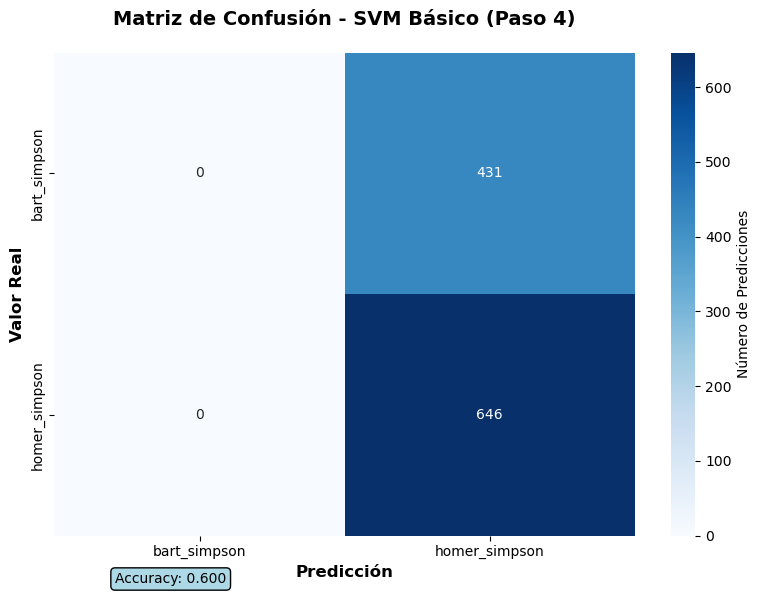

In [22]:
# Recrear las predicciones para asegurar consistencia usando constantes del proyecto
print("🎯 Generando visualizaciones de matrices de confusión...\n")

# 1. SVM Básico (Paso 4)
# Necesitamos recrear el modelo SVM básico y sus predicciones
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preparar datos para SVM básico usando constantes
le_basic = LabelEncoder()
etiquetas_codificadas_basic = le_basic.fit_transform(etiquetas)
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(
    features, etiquetas_codificadas_basic, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

# Entrenar SVM básico
modelo_svm_basic = SVC(kernel="linear", C=1.0)
modelo_svm_basic.fit(X_train_basic, y_train_basic)
y_pred_svm_basic = modelo_svm_basic.predict(X_test_basic)

# Plot matriz de confusión SVM básico usando constantes
plot_confusion_matrix(y_test_basic, y_pred_svm_basic, 
                     le_basic.classes_, 
                     "SVM Básico (Paso 4)")

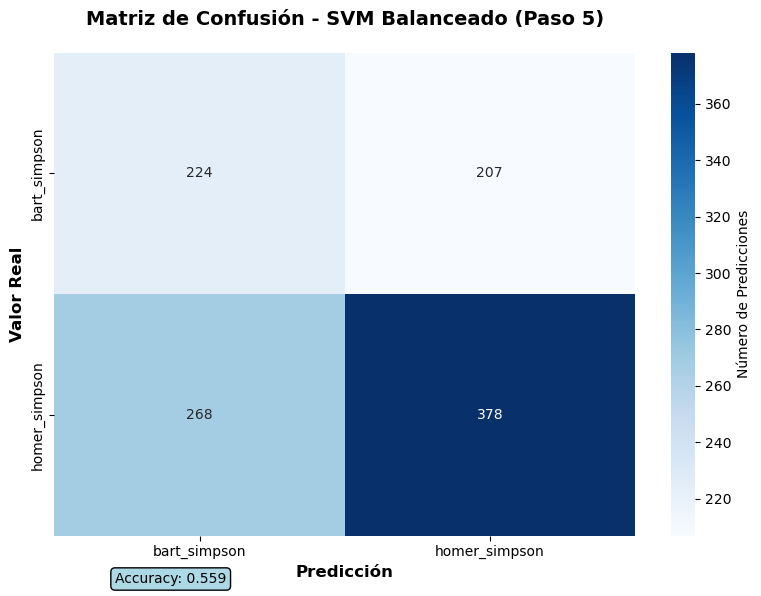

In [23]:
# 2. SVM Balanceado (Paso 5)
# Entrenar SVM con class_weight='balanced'
modelo_svm_balanced = SVC(kernel="linear", C=1.0, class_weight='balanced')
modelo_svm_balanced.fit(X_train_basic, y_train_basic)
y_pred_svm_balanced = modelo_svm_balanced.predict(X_test_basic)

# Plot matriz de confusión SVM balanceado usando tamaño de figura por defecto
plot_confusion_matrix(y_test_basic, y_pred_svm_balanced, 
                     le_basic.classes_, 
                     "SVM Balanceado (Paso 5)")

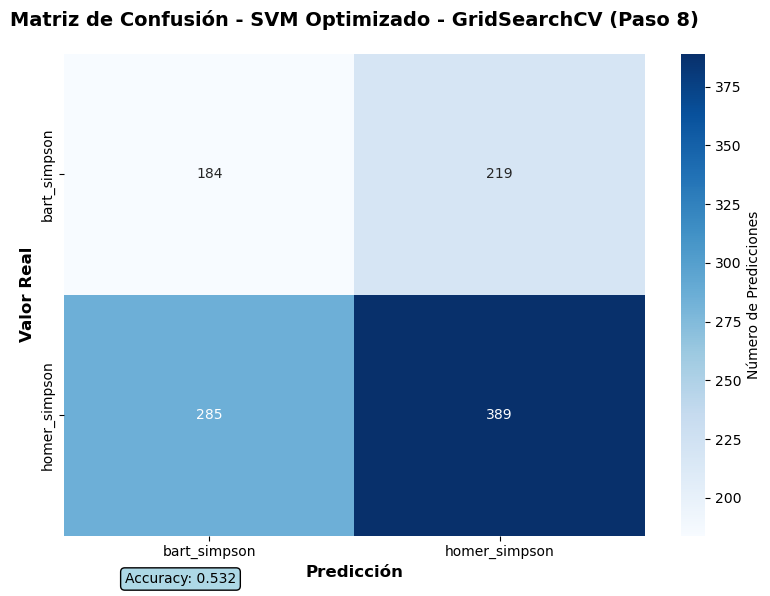

In [24]:
# 3. SVM Optimizado con GridSearchCV (Paso 8)
# Usamos el modelo óptimo ya entrenado y las predicciones existentes
plot_confusion_matrix(y_test, y_pred_optimo, 
                     le.classes_, 
                     "SVM Optimizado - GridSearchCV (Paso 8)")

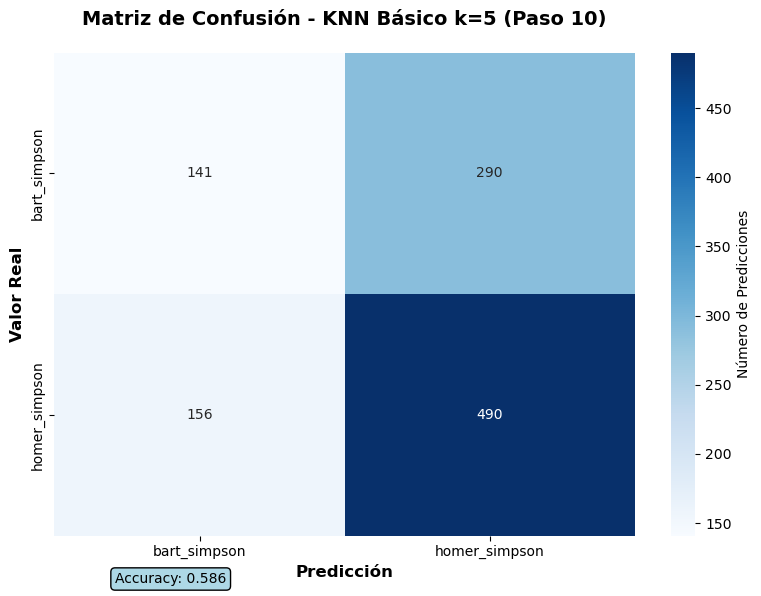

In [25]:
# 4. KNN Básico (Paso 10)
# Recrear KNN básico usando constantes del proyecto
from sklearn.neighbors import KNeighborsClassifier

modelo_knn_basic = KNeighborsClassifier(n_neighbors=DEFAULT_K)
modelo_knn_basic.fit(X_train_basic, y_train_basic)
y_pred_knn_basic = modelo_knn_basic.predict(X_test_basic)

# Plot matriz de confusión KNN básico
plot_confusion_matrix(y_test_basic, y_pred_knn_basic, 
                     le_basic.classes_, 
                     f"KNN Básico k={DEFAULT_K} (Paso 10)")

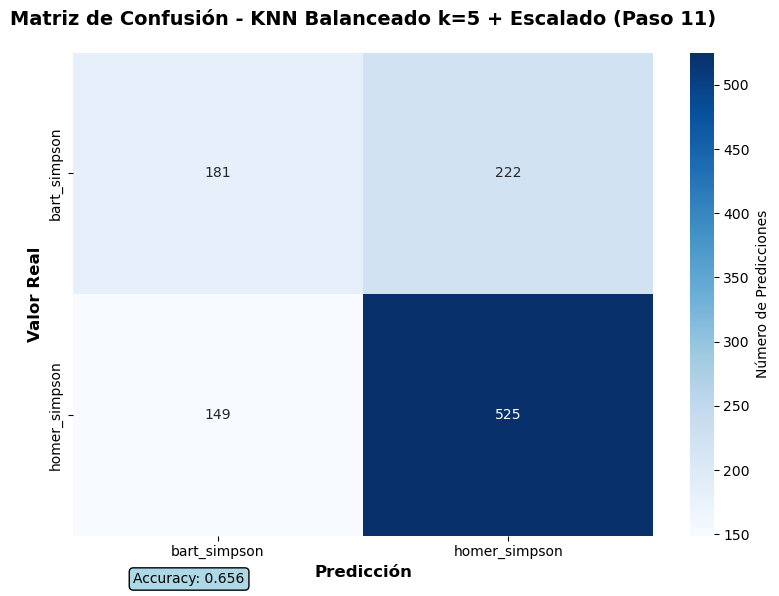

In [26]:
# 5. KNN Balanceado con Escalado (Paso 11)
# Recrear el modelo KNN balanceado con escalado usando constantes del proyecto
from sklearn.preprocessing import StandardScaler

# Preparar datos escalados
scaler_viz = StandardScaler()
features_scaled_viz = scaler_viz.fit_transform(np.array(features))

# División estratificada usando constantes del proyecto
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    features_scaled_viz, etiquetas_codificadas_basic, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=etiquetas_codificadas_basic
)

# Entrenar KNN balanceado usando K por defecto
modelo_knn_balanced = KNeighborsClassifier(n_neighbors=DEFAULT_K, weights='distance')
modelo_knn_balanced.fit(X_train_scaled, y_train_scaled)
y_pred_knn_balanced = modelo_knn_balanced.predict(X_test_scaled)

# Plot matriz de confusión KNN balanceado
plot_confusion_matrix(y_test_scaled, y_pred_knn_balanced, 
                     le_basic.classes_, 
                     f"KNN Balanceado k={DEFAULT_K} + Escalado (Paso 11)")


📊 Creando comparación visual de todas las matrices de confusión...


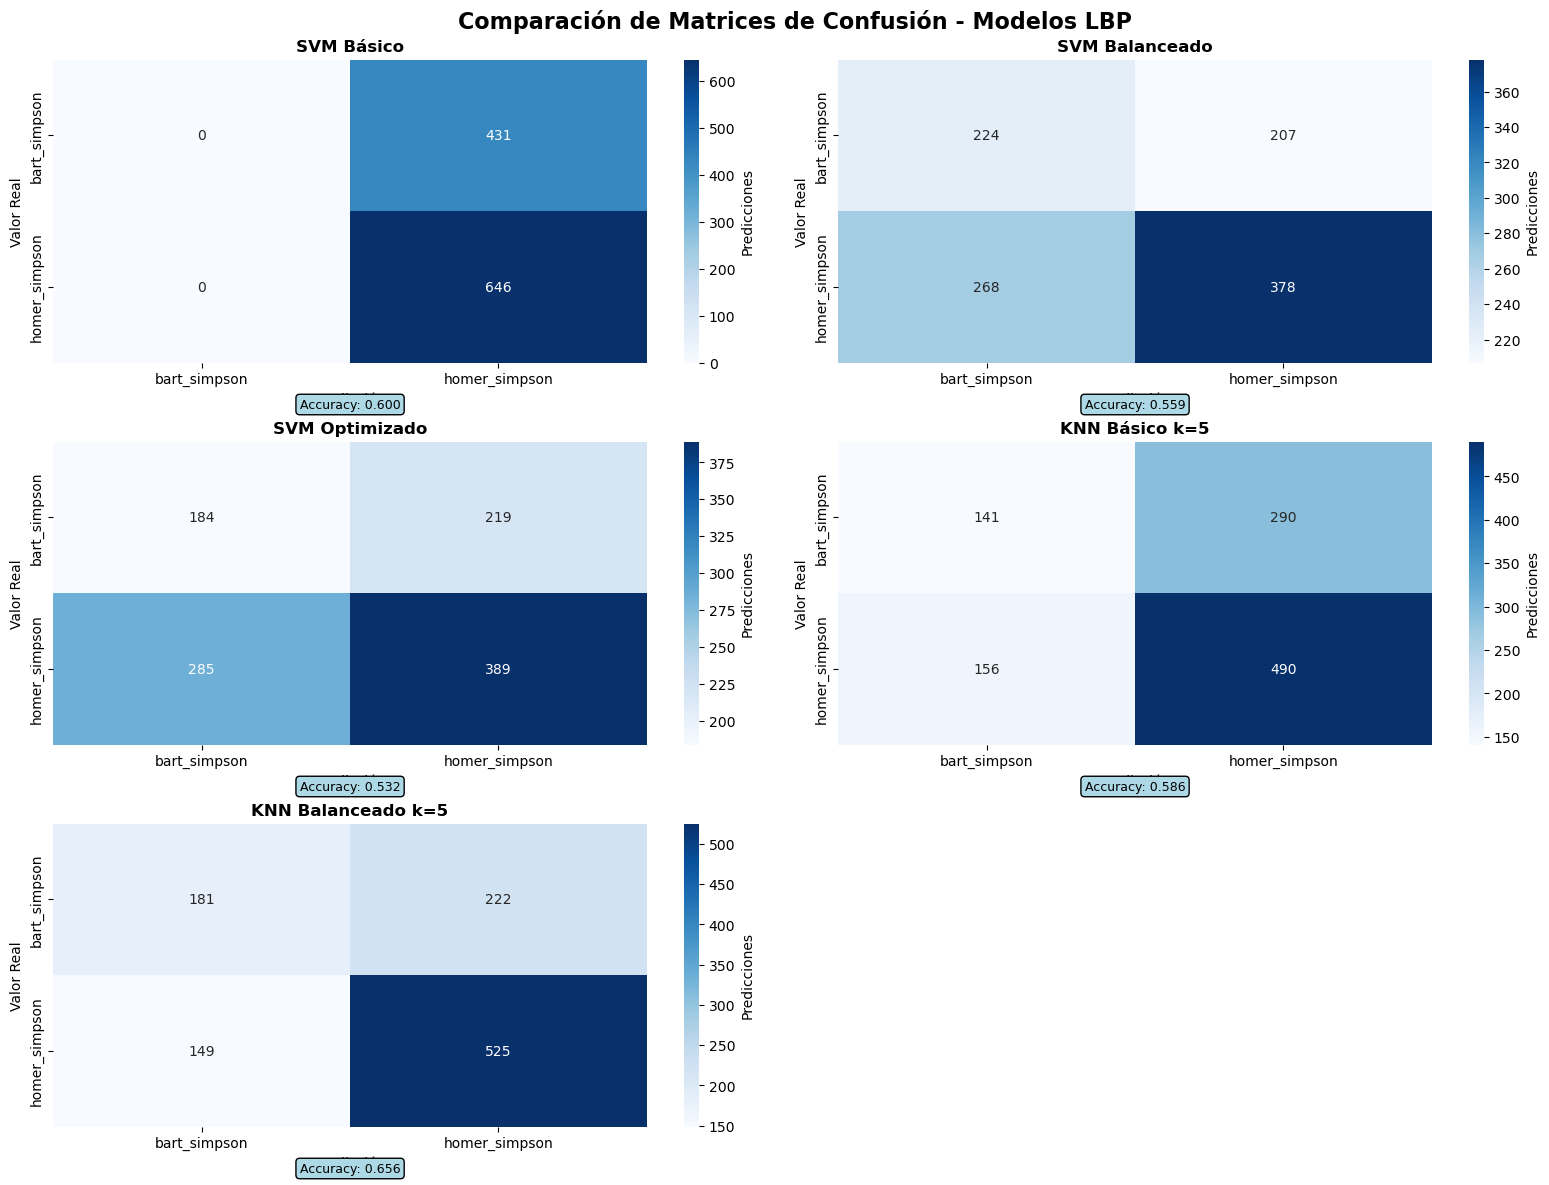

In [27]:
# 6. Comparación Visual de Todos los Modelos
print("\n📊 Creando comparación visual de todas las matrices de confusión...")

# Preparar datos para la función de comparación múltiple
matrices_info = [
    (y_test_basic, y_pred_svm_basic, le_basic.classes_, "SVM Básico"),
    (y_test_basic, y_pred_svm_balanced, le_basic.classes_, "SVM Balanceado"),
    (y_test, y_pred_optimo, le.classes_, "SVM Optimizado"),
    (y_test_basic, y_pred_knn_basic, le_basic.classes_, f"KNN Básico k={DEFAULT_K}"),
    (y_test_scaled, y_pred_knn_balanced, le_basic.classes_, f"KNN Balanceado k={DEFAULT_K}")
]

# Crear plot comparativo usando tamaño de figura por defecto para múltiples plots
plot_multiple_confusion_matrices(matrices_info)

In [28]:
# 7. Análisis Cuantitativo de las Matrices de Confusión
print("📈 Resumen Cuantitativo de Rendimiento por Modelo:\n")

def analyze_confusion_matrix(y_true, y_pred, model_name):
    """Función para analizar métricas de una matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Métricas globales
    accuracy = np.trace(cm) / np.sum(cm)
    
    # Métricas por clase
    tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (cm[0,0], cm[0,1], cm[1,0], cm[1,1])
    
    # Precisión y recall por clase
    precision_clase_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    recall_clase_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    precision_clase_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_clase_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"🤖 {model_name}:")
    print(f"   Accuracy Global: {accuracy:.3f}")
    print(f"   Bart Simpson  - Precisión: {precision_clase_0:.3f}, Recall: {recall_clase_0:.3f}")
    print(f"   Homer Simpson - Precisión: {precision_clase_1:.3f}, Recall: {recall_clase_1:.3f}")
    print(f"   Matriz: {cm.tolist()}")
    print()

# Analizar todos los modelos
analyze_confusion_matrix(y_test_basic, y_pred_svm_basic, "SVM Básico")
analyze_confusion_matrix(y_test_basic, y_pred_svm_balanced, "SVM Balanceado")
analyze_confusion_matrix(y_test, y_pred_optimo, "SVM Optimizado (GridSearchCV)")
analyze_confusion_matrix(y_test_basic, y_pred_knn_basic, "KNN Básico k=5")
analyze_confusion_matrix(y_test_scaled, y_pred_knn_balanced, "KNN Balanceado k=5 + Escalado")

📈 Resumen Cuantitativo de Rendimiento por Modelo:

🤖 SVM Básico:
   Accuracy Global: 0.600
   Bart Simpson  - Precisión: 0.000, Recall: 0.000
   Homer Simpson - Precisión: 0.600, Recall: 1.000
   Matriz: [[0, 431], [0, 646]]

🤖 SVM Balanceado:
   Accuracy Global: 0.559
   Bart Simpson  - Precisión: 0.455, Recall: 0.520
   Homer Simpson - Precisión: 0.646, Recall: 0.585
   Matriz: [[224, 207], [268, 378]]

🤖 SVM Optimizado (GridSearchCV):
   Accuracy Global: 0.532
   Bart Simpson  - Precisión: 0.392, Recall: 0.457
   Homer Simpson - Precisión: 0.640, Recall: 0.577
   Matriz: [[184, 219], [285, 389]]

🤖 KNN Básico k=5:
   Accuracy Global: 0.586
   Bart Simpson  - Precisión: 0.475, Recall: 0.327
   Homer Simpson - Precisión: 0.628, Recall: 0.759
   Matriz: [[141, 290], [156, 490]]

🤖 KNN Balanceado k=5 + Escalado:
   Accuracy Global: 0.656
   Bart Simpson  - Precisión: 0.548, Recall: 0.449
   Homer Simpson - Precisión: 0.703, Recall: 0.779
   Matriz: [[181, 222], [149, 525]]

